In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd

In [24]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [26]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

ArgumentError: Invalid SQLite URL: sqlite://../Resources/hawaii.sqlite
Valid SQLite URL forms are:
 sqlite:///:memory: (or, sqlite://)
 sqlite:///relative/path/to/file.db
 sqlite:////absolute/path/to/file.db

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
print(f'Measurements tables')
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    
print()
print("stations tables")
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

Measurements tables
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

stations tables
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#last date in db
lastDay = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(lastDay)

# Calculate the date 1 year ago from the last data point in the database
#last day minus one year
days = dt.timedelta(365)
aYearBefore = dt.date(2017, 8, 23) - days
print (aYearBefore)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > aYearBefore).order_by(Measurement.date).all()
# print(percip)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp)
prcp_df = prcp_df.set_index('date')
prcp_df.head(10)

prcp_df = prcp_df.sort_values(by = ['date'])

# prcp_df = prcp_df.dropna(how='all')

prcp_df.head(10)

('2017-08-23',)
2016-08-23


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


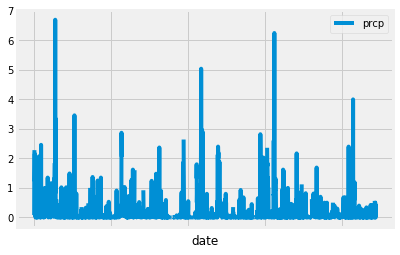

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x_compat=True)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
stations

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activeStation = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
                        order_by(func.count(Measurement.tobs).desc()).all()
print(activeStation)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
topStationTemps =  session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == activeStation[0][0]).\
        order_by(Measurement.tobs).all()
print(topStationTemps)

[(54.0, 85.0, 71.66378066378067)]


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
        filter(Measurement.station == activeStation[0][0]).\
        filter(Measurement.date > aYearBefore).group_by(Measurement.date).all()

temp_df = pd.DataFrame(temp)
temp_df.head()



,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


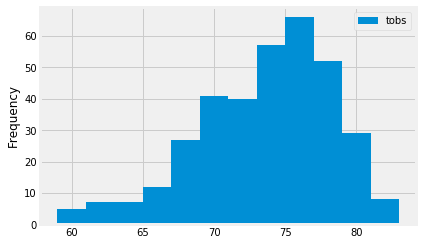

In [18]:
plt.hist(temp_df['tobs'], 12)
plt.ylabel('Frequency')
legend = ['tobs']
plt.legend(legend)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_dt = dt.date(2017, 3, 28)
end_dt = dt.date(2017, 4, 5)
trip_temp = calc_temps(start_dt,end_dt)
print(trip_temp)

[(67.0, 74.65, 80.0)]


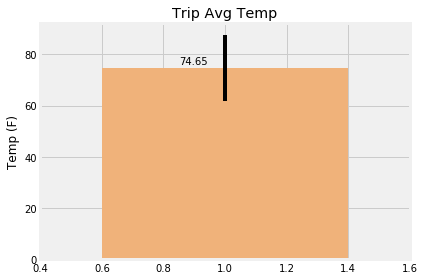

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#variables for plotting
min_temp = trip_temp[0][0]
max_temp = trip_temp[0][2]
avg_temp = trip_temp[0][1]
peak_to_peak = max_temp - min_temp
 
#Graph plot
fig, ax = plt.subplots()
trip = ax.bar( 1, avg_temp, color = '#F0B27A', yerr = peak_to_peak)

#text for labels, title and custom x-axis tick labels, etc.

ax.set_title('Trip Avg Temp')
ax.set_ylabel( "Temp (F)")



def autolabel(rects, xpos='left'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(trip)
plt.xlim(.4, 1.6)
fig.tight_layout()
plt.show()

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# importatnt to filter between the start and end date of trip
rainFall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
                        Measurement.prcp)\
        .filter(Measurement.date>= start_dt).filter(Measurement.date<= end_dt).order_by(Measurement.station).all()

print(rainFall)

[('USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.03), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.03), ('USC00513117', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00513117', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.03), ('USC00513117', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.03), ('USC00513117', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.03), ('USC00513117', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.03), ('USC00513117', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.03), ('USC00513117', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.03), ('USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00513117', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00513117', 'PEARL CITY, HI US', 21.393

## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
